In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
#Base cofficients (now: random!)
BASE_WEIGHTS = { #sum to 1!
    'age': 0.2,
    'income': 0.15,
    # 'openness': 0.1,
    # 'conscientiousness': 0.1,
    # 'extraversion': 0.1,
    # 'agreeableness': 0.1,
    # 'neuroticism': 0.1,
    # 'depressed_mood': 0.05,
    # 'anhedonia': 0.05,
    # 'weight_change': 0.05,
    # 'sleep_disturbance': 0.05,
    # 'psychomotor': 0.05,
    # 'fatigue': 0.05,
    # 'worthlessness': 0.05,
    # 'concentration': 0.05,
    # 'suicidal_ideation': 0.05,
    'total_depressive_symptoms': 0.1,
    'education': 0.1,
    'ethnicity': 0.1,
    'gender': 0.2,
    'religion': 0.15
}

MAX_DISTANCES = {
    'age': 100,
    'income': 26722.27,
    # 'openness': 4,
    # 'conscientiousness': 4,
    # 'extraversion': 4,
    # 'agreeableness': 4,
    # 'neuroticism': 4,
    # 'depressed_mood': 3,
    # 'anhedonia': 3,
    # 'weight_change': 3,
    # 'sleep_disturbance': 3,
    # 'psychomotor': 3,
    # 'fatigue': 3,
    # 'worthlessness': 3,
    # 'concentration': 3,
    # 'suicidal_ideation': 3,
    'total_depressive_symptoms': 27,
    'education': 1,
    'ethnicity': 1,
    'gender': 1,
    'religion': 1
}

MAX_HOURS = 39
MAX_DISTANCE = sum(BASE_WEIGHTS[key] * MAX_DISTANCES[key] for key in BASE_WEIGHTS)


Set-up

In [3]:
seed = 123
n = 15 #support group size
data = pd.read_csv('synthetic_data_categ.csv')
support_group_data = data.sample(n=n, random_state=seed).reset_index(drop=True)
print(support_group_data)

      age  gender      income total_depressive_symptoms  ethnicity  \
0   25-49    Male      30-60%                  Moderate  Non-dutch   
1   25-49  Female  Bottom 30%                      Mild  Non-dutch   
2   25-49  Female  Bottom 30%                  Moderate  Non-dutch   
3   25-49    Male      60-90%                      Mild      Dutch   
4   25-49  Female  Bottom 30%                      Mild  Non-dutch   
5   25-49    Male      30-60%                      Mild      Dutch   
6     ≥50    Male  Bottom 30%                  Moderate      Dutch   
7   25-49   Other  Bottom 30%                  Moderate  Non-dutch   
8   25-49    Male  Bottom 30%                      Mild      Dutch   
9   25-49  Female  Bottom 30%                      Mild      Dutch   
10  25-49  Female      60-90%                  Moderate      Dutch   
11  25-49  Female      60-90%                  Moderate      Dutch   
12  25-49    Male        90+%                      Mild  Non-dutch   
13  25-49    Male   

Create a graph

In [4]:
G = nx.complete_graph(n)

for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

Define the homophily function

In [5]:
def homophily_function(node1, node2, G, weights): #TODO: incorporate euclidean distance?
    '''Homophily function for edge prediction
    The output should be the number of hours the two people in the edge spend together'''

    normalized_total_distance = 0
    max_normalized_total_distance = sum(weights.values())

    for attribute, weight in weights.items():
        value1 = G.nodes[node1].get(attribute)
        value2 = G.nodes[node2].get(attribute)
        max_attribute_distance = MAX_DISTANCES[attribute]

        #handle continuous variables
        if isinstance(value1, (int, float)) and isinstance(value2, (int, float)): #TODO: add handling o NA values
            absolute_distance = abs(value1 - value2)
            normalized_distance = absolute_distance / max_attribute_distance
            weighted_normalized_distance = normalized_distance * weight
            normalized_total_distance += weighted_normalized_distance

        #handle categorical variables
        elif isinstance(value1, str) and isinstance(value2, str):
            normalized_distance = 1 if value1 != value2 else 0
            normalized_total_distance += weight * normalized_distance

    #Convert distance to hours
    #TODO: use a nonmonotonic function here according to Bruggeman
    # Rescale distance to hours
    hours = MAX_HOURS * (1 - (normalized_total_distance / max_normalized_total_distance)) # nodes identical: max hours spent; max distance: 0 hours
    hours = round(hours, 2)
    return hours

Assign weights based on the homophily function

In [6]:
for node1, node2 in G.edges():
    weight = homophily_function(node1, node2, G, BASE_WEIGHTS)
    G.edges[node1, node2]['weight'] = weight

Display graph

{(0, 1): Text(0.2951065302823893, 0.8226071781153931, '11.7'),
 (0, 2): Text(0.49982500743693364, 0.5362770126221672, '25.35'),
 (0, 3): Text(-0.25943917575573444, 0.43361316120493193, '15.6'),
 (0, 4): Text(0.27891972004847887, 0.10409172986657894, '11.7'),
 (0, 5): Text(-0.44320022099497747, 0.765278194461281, '31.2'),
 (0, 6): Text(0.3168870049399626, 0.6453078571700547, '11.7'),
 (0, 7): Text(-0.3153326270980121, 0.19259024615943948, '21.45'),
 (0, 8): Text(-0.05508342857194454, 0.6779898157614331, '15.6'),
 (0, 9): Text(0.0784097933999353, 0.4252561374842523, '17.55'),
 (0, 10): Text(0.05776680733275995, 0.1464900159481209, '11.7'),
 (0, 11): Text(0.42953460166624036, 0.28741820759501113, '15.6'),
 (0, 12): Text(-0.48490270754007503, 0.5160294232215998, '25.35'),
 (0, 13): Text(-0.2255890764706926, 0.866094448273859, '19.5'),
 (0, 14): Text(-0.17517713199512658, 0.010006971623753746, '23.4'),
 (1, 2): Text(0.7952815228454557, 0.3697995138901948, '25.35'),
 (1, 3): Text(0.036017339

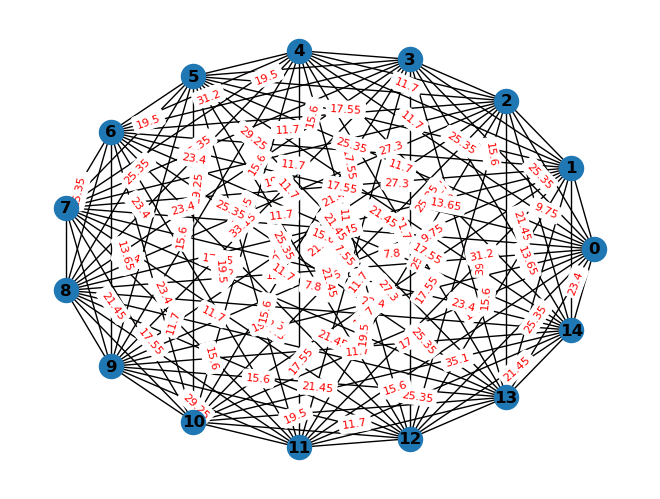

In [7]:
pos=nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=edge_labels, font_size=8, font_color='red')


Linear regression to extract coefficients

In [8]:
#data prep

def prepare_regression_data(G, attributes, max_hours):
    '''Prepares data for regression'''
    data = []

    for node1, node2, edge in G.edges(data=True):
        row = {}

        for attr in attributes:
            value1 = G.nodes[node1].get(attr, 0)
            value2 = G.nodes[node2].get(attr, 0)
            max_attribute_distance = MAX_DISTANCES[attr]

            # Absolute differences for continuous attributes
            if isinstance(value1, (int, float)) and isinstance(value2, (int, float)): #TODO: add handling o NA values
                absolute_distance = abs(value1 - value2)
                normalized_distance = absolute_distance / max_attribute_distance
                row[attr] = - normalized_distance

            # Binary differences for categorical attributes
            elif isinstance(value1, str) and isinstance(value2, str):
                row[attr] = - 1 if value1 != value2 else 0 #minus because distance has negative contribution to hours
                
        row['target'] = edge['weight']
        data.append(row)      

    return pd.DataFrame(data)

Regression

In [9]:
attributes = list(support_group_data.columns.values)
regression_data = prepare_regression_data(G, attributes, MAX_HOURS)

X = regression_data[attributes]
Y = regression_data['target']

#fit
model = LinearRegression()
model.fit(X, Y)

recovered_weights = pd.Series(model.coef_, index=attributes)
normalized_recovered_weights = recovered_weights / recovered_weights.sum() #normalize weights
normalized_recovered_weights = normalized_recovered_weights.to_dict() #convert to a dictionary


Comparison

In [10]:
# Combine into a DataFrame for comparison
comparison = pd.DataFrame({
    'Base Weights': BASE_WEIGHTS,
    'Recovered Weights': normalized_recovered_weights
})

# Display the comparison
print(comparison)

                           Base Weights  Recovered Weights
age                                0.20               0.20
income                             0.15               0.15
total_depressive_symptoms          0.10               0.10
education                          0.10               0.10
ethnicity                          0.10               0.10
gender                             0.20               0.20
religion                           0.15               0.15


Regenerate a graph with recovered weights

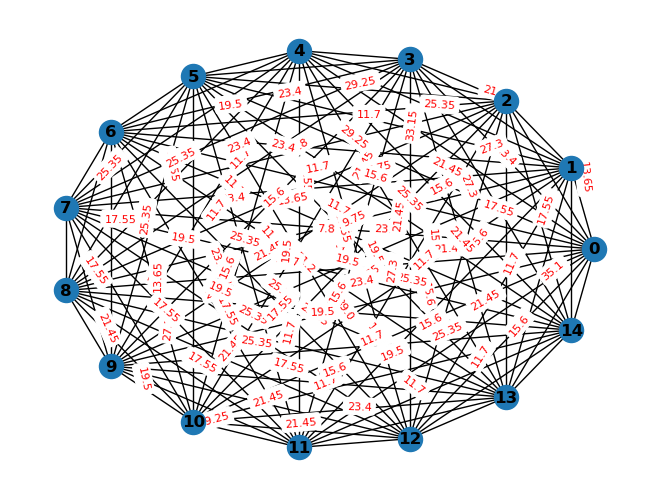

In [ ]:
G_recovered = nx.complete_graph(n)

#assign attributes to the recovered graph (same as in the original graph)
for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

#assign weights based on homophily function
for node1, node2 in G_recovered.edges():
    weight = homophily_function(node1, node2, G, normalized_recovered_weights)
    G_recovered.edges[node1, node2]['weight'] = weight

#display graph
pos=nx.circular_layout(G_recovered)
nx.draw(G_recovered, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G_recovered, 'weight')
nx.draw_networkx_edge_labels(G_recovered, pos=nx.spring_layout(G_recovered), edge_labels=edge_labels, font_size=8, font_color='red');

Compare original network with recovered

In [13]:
nx.graph_edit_distance(G, G_recovered)

0.0

In [14]:
nx.is_isomorphic(G, G_recovered)

True